In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy
import csv
from scipy import signal, stats, spatial, optimize, interpolate
from scipy.signal import butter, lfilter, resample, lfilter
import scipy.signal
from statistics import mean

def opencsv(name):
    with open(name) as fp:
        skip = next(filter(
            lambda x: x[1].startswith('timestamp'),
            enumerate(fp)
        ))[0]
    df = pd.read_csv(name, skiprows=skip)
    df.drop(df.tail(4).index,
            inplace = True)
    df['timestamp']=df['timestamp'].astype(float).astype(int)
    return df

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, fs, cutoff, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def peakfind(x):
    peaks, _ = scipy.signal.find_peaks(x, distance=40, prominence=200)
    return peaks

def deriv_n(signal):
    r = np.gradient(signal, 1)
    while len(r) < len(signal):
        r = np.append(r, r[-1])
    return r

class Pulse:
    def __init__(self, data, pressure, kind):
        self.data = data
        self.pressure = pressure
        self.kind = kind

def classify(sig):        
    peaks, props = signal.find_peaks(sig, prominence=0.02)
    peaks = [y for y in peaks if sig[y] > 0.45]

    if len(peaks) >= 3:
        return 3
    
    ### Notch
    if len(peaks) == 2:
        if (sig[peaks[0]] - sig[peaks[1]]) > 0.1:
            return '2L'

        elif (sig[peaks[0]] - sig[peaks[1]]) < -0.1:
            return '2R'

        else:
            peaks, _ = signal.find_peaks(sig)
            peaks = [y for y in peaks if sig[y] > 0.45]
            if len(peaks) == 2:
                return '2E'
            else:
                return '3'
            
    else:
        peaks, props = signal.find_peaks(sig, distance=5)
        peaks = [y for y in peaks if sig[y] > 0.45]
        if len(peaks) >= 2:
            if (sig[peaks[0]] - sig[peaks[1]]) > 0.1:
                return '2L'

            elif (sig[peaks[0]] - sig[peaks[1]]) < -0.1:
                return '2R'

            else:
                return '2E'
        elif len(peaks) == 1:
            peaks, props = signal.find_peaks(sig, distance=5, prominence=0.2)
            peaks = [y for y in peaks if sig[y] > 0.45]
        
            if peaks[0] < 25:
                print(peaks[0])
                return '1L'
            else:
                return '1'
        else:
            return '3'

In [2]:
df_ppg_ref = opencsv('ppg1.csv')
df_pressure = pd.read_csv('p1.csv')
start = min(df_pressure['time'])

df_ppg_ref['timestamp']-=start
df_ppg_ref['timestamp']/=1000

df_ppg_ref['PPG_LPF_10Hz'] = butter_lowpass_filter(df_ppg_ref['LEDC1'], 128, 10)

df_pressure['time']-=start
df_pressure['voltage_ref'] = 5 - df_pressure['reading'] / 1023 * 5
df_pressure['time']/=1000

df_ppg_ref = df_ppg_ref[df_ppg_ref['timestamp'] >=0].copy()

/var/folders/14/vycwhyn93jxbg775qr34_4tr0000gn/T/ipykernel_59286/3133627192.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, skiprows=skip)


<Axes: xlabel='timestamp'>

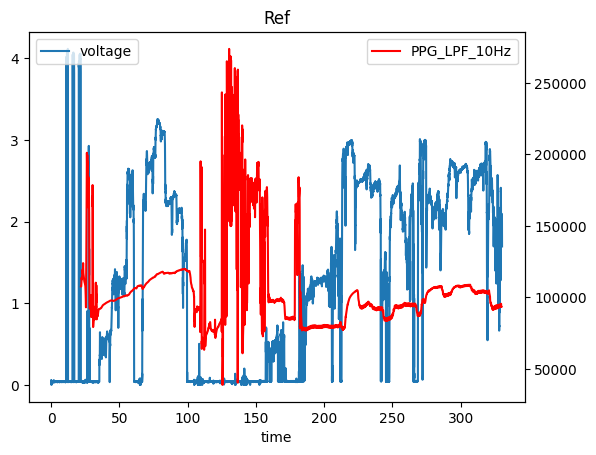

In [3]:
ax = df_pressure.plot(x='time', y='voltage_ref')
ax.set_title('Ref')
h,l = ax.get_legend_handles_labels()
ax.legend(h[:2], ['voltage'], loc=2)
ax = ax.twinx()
df_ppg_ref[1600:].plot(ax=ax, x='timestamp', y='PPG_LPF_10Hz', color="r")

-2.072999999999997


<Axes: xlabel='timestamp'>

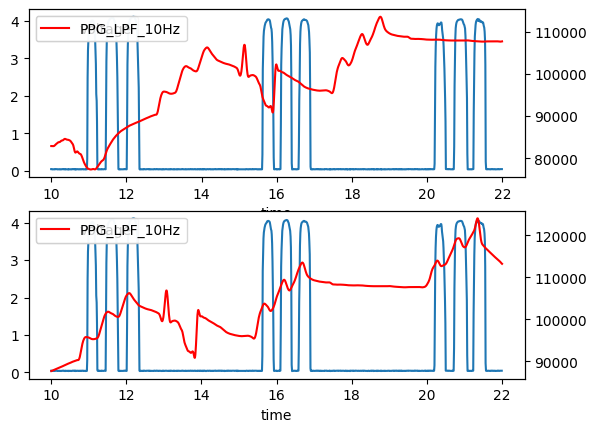

In [4]:
# Synchronising PPG in and pressure
vs = 10
ve = 22

pres_s = 20
pres_e = 24
ppg_s = 10
ppg_e = 24

fig, axes = plt.subplots(2, 1)

axes[0] = df_pressure[df_pressure['time'].between(vs, ve)].plot(ax=axes[0], x='time', y='voltage_ref')
h,l = axes[0].get_legend_handles_labels()
axes[0].legend(h[:2], ['voltage'], loc=2)
axes[0] = axes[0].twinx()
df_ppg_ref[df_ppg_ref['timestamp'].between(vs, ve)].plot(ax=axes[0], x='timestamp', y='PPG_LPF_10Hz', color="r")

pres_max = df_pressure[df_pressure['time'].between(pres_s, pres_e)]['voltage_ref'].idxmax()
ppg_min = df_ppg_ref[df_ppg_ref['timestamp'].between(ppg_s, ppg_e)]['LEDC1'].idxmax()

correction = df_pressure.loc[pres_max]['time'] - df_ppg_ref.loc[ppg_min]['timestamp']
print(correction)
df_ppg_ref['timestamp'] += correction

axes[1] = df_pressure[df_pressure['time'].between(vs, ve)].plot(ax=axes[1], x='time', y='voltage_ref')
h,l = axes[1].get_legend_handles_labels()
axes[1].legend(h[:2], ['voltage'], loc=2)
axes[1] = axes[1].twinx()
df_ppg_ref[df_ppg_ref['timestamp'].between(vs, ve)].plot(ax=axes[1], x='timestamp', y='PPG_LPF_10Hz', color="r")

In [5]:
end = min(max(df_ppg_ref['timestamp']), max(df_pressure['time']))

df_ppg_ref = df_ppg_ref[df_ppg_ref['timestamp'].between(24, end)].copy()
df_pressure = df_pressure[df_pressure['time'].between(24, end)].copy()

df_pressure['Ref'] = signal.resample(df_ppg_ref['PPG_LPF_10Hz'], len(df_pressure))
df = df_pressure[['time', 'Ref', 'voltage_ref']].copy()

peaks = peakfind(df['Ref'].values)
line = interpolate.CubicSpline(df['time'].values[peaks], df['Ref'].values[peaks])
df['Ref'] = (df['Ref'] - line(df['time'].values))*-1

In [6]:
t = 5

filtered_ref = []
filtered_pres_ref = []

def high_foot_correction(peak):
    high_foot = max(peak[0], peak[-1])
    if high_foot > 0:
        peak -= high_foot
        ori = len(peak)
        peak = [i for i in peak if i >= 0]
    
    return peak

   
allpeaks = []

data_ref = df['Ref'].values
peaks_ref = peakfind(-data_ref)
pres_ref = df['voltage_ref'].values
max_ref = len(peaks_ref)

i_ref = 0

while i_ref < max_ref - 1:
    while (i_ref < max_ref - 1 and (peaks_ref[i_ref+1] - peaks_ref[i_ref] >= 110 or peaks_ref[i_ref+1] - peaks_ref[i_ref] <= 35)):
        i_ref += 1

    if i_ref < max_ref - 1:
        if data_ref[peaks_ref[i_ref+1]] < t and data_ref[peaks_ref[i_ref+1]] > -t:
            peak_ref = high_foot_correction(data_ref[peaks_ref[i_ref]:peaks_ref[i_ref+1]])
            peak_ref/=max(peak_ref)
            
            filtered_ref.extend(signal.resample(peak_ref, 100))
            filtered_pres_ref.extend(signal.resample(pres_ref[peaks_ref[i_ref]:peaks_ref[i_ref+1]], 100))

    i_ref+=1

In [7]:
print(len(filtered_ref))
print(len(filtered_pres_ref))

17300
17300


In [8]:
pres = []
typ = []
pulses = []

for i in range(0, len(filtered_ref), 100):
    pres.append(mean(filtered_pres_ref[i:i+100]))
    
    kind = classify(filtered_ref[i:i+100])
    typ.append(kind)
    pulses.append(Pulse(filtered_ref[i:i+100], mean(filtered_pres_ref[i:i+100]), kind))
    

16


<Axes: >

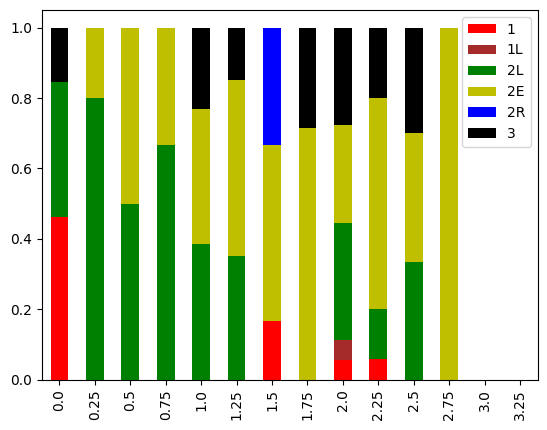

In [9]:
steps = (np.linspace(0, 3.5, 15))
kinds = ['1', '1L', '2L', '2E', '2R', '3']

bars = [ [ 0 for _ in range(14) ] for _ in range(6) ]

for i in range(14):
    for j, k in enumerate(kinds):
        bars[j][i] = len([p for p in pulses if p.kind == k and p.pressure >= steps[i] and p.pressure < steps[i+1]])

dfb = pd.DataFrame(np.array(bars), index=kinds, columns=steps[:-1])


for column in dfb.columns:
    if sum(dfb[column]) > 0:
        dfb[column] *= 1/sum(dfb[column])

dfb.transpose().plot(kind='bar', stacked=True, color=['r', 'brown', 'g', 'y', 'b', 'black'])

In [ ]:
classify()